In [27]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators




class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier."""

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Fit classifiers."""
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """Predict class labels."""
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        return self.lablenc_.inverse_transform(maj_vote)

    def predict_proba(self, X):
        """Predict class probabilities."""
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch."""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


In [28]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Iris dataset (only versicolor vs virginica)
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

# Encode labels into {0, 1}
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)



In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Define base classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Pipelines for scaling
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')

# Evaluate individual classifiers
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                             cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" %
          (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]


In [38]:

# Create majority rule classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


ROC AUC: 0.80 (+/- 0.08) [Logistic regression]
ROC AUC: 0.62 (+/- 0.02) [Decision tree]
ROC AUC: 0.92 (+/- 0.08) [KNN]
ROC AUC: 0.69 (+/- 0.20) [Majority voting]


In [39]:
# Load Wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Drop class 1 and only use classes 2 and 3
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

# Encode labels and split data
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create decision tree classifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

# Create bagging classifier
bag = BaggingClassifier(estimator=tree, n_estimators=500,
                        max_samples=1.0, max_features=1.0,
                        bootstrap=True, bootstrap_features=False,
                        n_jobs=1, random_state=1)

# Train and evaluate individual decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Train and evaluate bagging classifier
bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


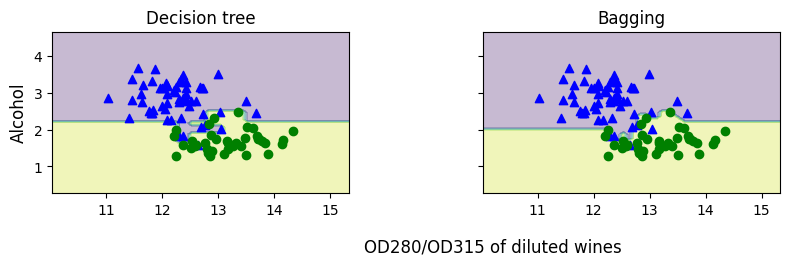

In [41]:

import matplotlib.pyplot as plt
import numpy as np

# Create mesh grid for plotting
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

In [34]:
from sklearn.ensemble import AdaBoostClassifier

# Create decision tree stump
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)

# Create AdaBoost classifier
ada = AdaBoostClassifier(estimator=tree, n_estimators=500,
                         learning_rate=0.1, random_state=1)

# Train individual decision tree stump
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree stump train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Train AdaBoost classifier
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision tree stump train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 0.968/0.917


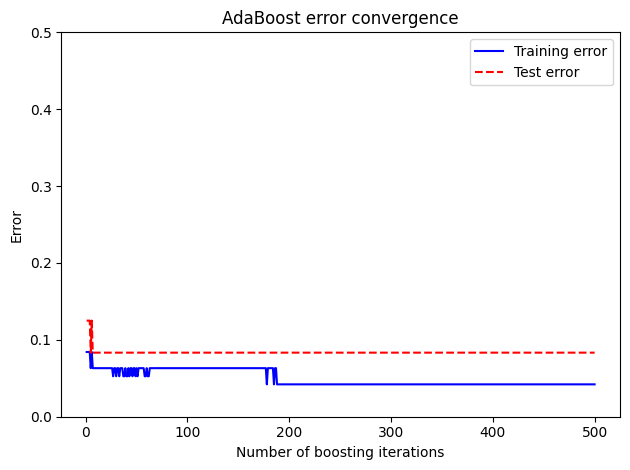

In [35]:

# Plot error convergence for AdaBoost
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
                         n_estimators=500, learning_rate=0.1, random_state=1)

ada.fit(X_train, y_train)
ada_train_err = []
ada_test_err = []

for y_train_pred, y_test_pred in zip(ada.staged_predict(X_train), ada.staged_predict(X_test)):
    ada_train_err.append(1 - accuracy_score(y_train, y_train_pred))
    ada_test_err.append(1 - accuracy_score(y_test, y_test_pred))

plt.plot(range(1, len(ada_train_err) + 1), ada_train_err, label='Training error', color='blue', linestyle='-')
plt.plot(range(1, len(ada_test_err) + 1), ada_test_err, label='Test error', color='red', linestyle='--')
plt.xlabel('Number of boosting iterations')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim(0, 0.5)
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

# Prepare Iris dataset for comprehensive comparison
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create individual classifiers
clf_lr = LogisticRegression(random_state=1, max_iter=1000)
clf_knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier(random_state=1)
clf_rf = RandomForestClassifier(random_state=1)

# Create ensemble methods
voting_clf = VotingClassifier(estimators=[
    ('lr', clf_lr), ('knn', clf_knn), ('dt', clf_dt), ('rf', clf_rf)], voting='hard')

bagging_clf = BaggingClassifier(estimator=clf_dt, n_estimators=100, random_state=1)
adaboost_clf = AdaBoostClassifier(estimator=clf_dt, n_estimators=100, random_state=1)

classifiers = [clf_lr, clf_knn, clf_dt, clf_rf, voting_clf, bagging_clf, adaboost_clf]
classifier_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest',
                    'Voting Classifier', 'Bagging', 'AdaBoost']

# Evaluate all classifiers
results = []
for clf, name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    results.append({
        'Classifier': name,
        'Mean Accuracy': scores.mean(),
        'Std Accuracy': scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values('Mean Accuracy', ascending=False))

            Classifier  Mean Accuracy  Std Accuracy
1                  KNN       0.951818      0.048285
0  Logistic Regression       0.941818      0.047621
4    Voting Classifier       0.940909      0.065839
5              Bagging       0.940909      0.065839
3        Random Forest       0.931818      0.063278
2        Decision Tree       0.922727      0.059231
6             AdaBoost       0.922727      0.071841


In [37]:

# Tune AdaBoost parameters
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=1))
gs_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)

print("AdaBoost Best parameters: ", gs_ada.best_params_)
print("AdaBoost Best score: ", gs_ada.best_score_)

# Tune Bagging parameters
param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bag = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_bag = GridSearchCV(bag, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
gs_bag.fit(X_train, y_train)

print("Bagging Best parameters: ", gs_bag.best_params_)
print("Bagging Best score: ", gs_bag.best_score_)

AdaBoost Best parameters:  {'estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Best score:  0.9714285714285713
Bagging Best parameters:  {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 200}
Bagging Best score:  0.9523809523809523


1. Compare the performance of the majority voting classifier with individual classifiers. Why does the ensemble typically perform better? Are there cases where it might perform worse? Bagging Analysis

Majority voting aggregates multiple perspectives, smoothing out mistakes of individual classifiers.

Individual classifiers might overfit specific patterns, the ensemble balances them.

Reduces variance and increases robustness.

Cases where it might perform worse:

If all individual classifiers are very weak or biased, voting may reinforce wrong predictions.

If classifiers are highly correlated, ensemble gain is minimal.

2. How does changing the number of estimators in bagging affect performance? What is the effect of bootstrap sampling vs using the entire dataset? Why does bagging typically reduce overfitting compared to a single decision tree?

Effects of changing numbers:

Small number of trees (1-10): unstable, high variance.

Moderate to large number (100-500): variance reduces, predictions stabilize.

Too many trees: marginal improvement, higher computational cost.

Bootstrap sampling vs full dataset:

Bootstrap creates diverse trees, reducing overfitting.

Using the full dataset for each tree removes this diversity leading to less variance reduction.

Why bagging reduces overfitting:

Single decision tree have high variance and sensitive to noise.

Bagging averages many independent trees makes predictions smooth and lowers variance.

3. How does the learning rate parameter affect AdaBoost's performance and convergence? Analyze the error convergence plot. Why does the test error sometimes increase after many iterations? What makes decision stumps good base estimators for AdaBoost?

Effect of learning rate:

Small learning rate: slower convergence, less risk of overfitting.

Large learning rate: faster convergence, but can overshoot and overfit.

Tradeoff: learning_rate * n_estimators controls total contribution of base learners.

Error convergence plot analysis:

Training error steadily decreases to near 0.

Test error often decreases initially, but may increase slightly after many iterations from overfitting to noise.

Why decision stumps are good base estimators:

Weak learners focus on misclassified samples each iteration.

Simple structure avoids overfitting while allowing AdaBoost to combine many weak learners into a strong classifier.

1. Compare the performance of the majority voting classifier with individual classifiers. Why does the ensemble typically perform better? Are there cases where it might perform worse? Bagging Analysis

Majority voting aggregates multiple perspectives, smoothing out mistakes of individual classifiers.

Individual classifiers might overfit specific patterns, the ensemble balances them.

Reduces variance and increases robustness.

Cases where it might perform worse:

If all individual classifiers are very weak or biased, voting may reinforce wrong predictions.

If classifiers are highly correlated, ensemble gain is minimal.

2. How does changing the number of estimators in bagging affect performance? What is the effect of bootstrap sampling vs using the entire dataset? Why does bagging typically reduce overfitting compared to a single decision tree?

Effects of changing numbers:

Small number of trees (1-10): unstable, high variance.

Moderate to large number (100-500): variance reduces, predictions stabilize.

Too many trees: marginal improvement, higher computational cost.

Bootstrap sampling vs full dataset:

Bootstrap creates diverse trees, reducing overfitting.

Using the full dataset for each tree removes this diversity leading to less variance reduction.

Why bagging reduces overfitting:

Single decision tree have high variance and sensitive to noise.

Bagging averages many independent trees makes predictions smooth and lowers variance.

3. How does the learning rate parameter affect AdaBoost's performance and convergence? Analyze the error convergence plot. Why does the test error sometimes increase after many iterations? What makes decision stumps good base estimators for AdaBoost?

Effect of learning rate:

Small learning rate: slower convergence, less risk of overfitting.

Large learning rate: faster convergence, but can overshoot and overfit.

Tradeoff: learning_rate * n_estimators controls total contribution of base learners.

Error convergence plot analysis:

Training error steadily decreases to near 0.

Test error often decreases initially, but may increase slightly after many iterations from overfitting to noise.

Why decision stumps are good base estimators:

Weak learners focus on misclassified samples each iteration.

Simple structure avoids overfitting while allowing AdaBoost to combine many weak learners into a strong classifier.

1. Compare the performance of the majority voting classifier with individual classifiers. Why does the ensemble typically perform better? Are there cases where it might perform worse? Bagging Analysis

Majority voting aggregates multiple perspectives, smoothing out mistakes of individual classifiers.

Individual classifiers might overfit specific patterns, the ensemble balances them.

Reduces variance and increases robustness.

Cases where it might perform worse:

If all individual classifiers are very weak or biased, voting may reinforce wrong predictions.

If classifiers are highly correlated, ensemble gain is minimal.

2. How does changing the number of estimators in bagging affect performance? What is the effect of bootstrap sampling vs using the entire dataset? Why does bagging typically reduce overfitting compared to a single decision tree?

Effects of changing numbers:

Small number of trees (1-10): unstable, high variance.

Moderate to large number (100-500): variance reduces, predictions stabilize.

Too many trees: marginal improvement, higher computational cost.

Bootstrap sampling vs full dataset:

Bootstrap creates diverse trees, reducing overfitting.

Using the full dataset for each tree removes this diversity leading to less variance reduction.

Why bagging reduces overfitting:

Single decision tree have high variance and sensitive to noise.

Bagging averages many independent trees makes predictions smooth and lowers variance.

3. How does the learning rate parameter affect AdaBoost's performance and convergence? Analyze the error convergence plot. Why does the test error sometimes increase after many iterations? What makes decision stumps good base estimators for AdaBoost?

Effect of learning rate:

Small learning rate: slower convergence, less risk of overfitting.

Large learning rate: faster convergence, but can overshoot and overfit.

Tradeoff: learning_rate * n_estimators controls total contribution of base learners.

Error convergence plot analysis:

Training error steadily decreases to near 0.

Test error often decreases initially, but may increase slightly after many iterations from overfitting to noise.

What makes decision stumps good base estimators:

Weak learners focus on misclassified samples each iteration.

Simple structure avoids overfitting while allowing AdaBoost to combine many weak learners into a strong classifier.

4. Which ensemble method performed best on the Iris dataset? Why do you think this is? How does Random Forest (which you used in the comparison) relate to bagging? When would you choose one ensemble method over another?

AdaBoost performed best because it adaptively focused on difficult samples.

Random Forest is essentially bagging with feature randomness which is good for reducing overfitting and improving generalization.

Choice depends on dataset:

Bagging: high-variance models, noisy data.

AdaBoost: clean data, weak learners, focus on difficult samples.

Voting: diverse strong classifiers